In [1]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt

In [2]:
def data_process(train_x, train_y, test_x):
    """数据预处理"""
    x_train = np.array(train_x.iloc[:, 1:])
    y_train = np.array(train_y.iloc[:, 1:])
    x_test = np.array(test_x.iloc[:, 1:])
    return x_train, y_train, x_test

In [3]:
def normalize(X, train=True, X_mean=None, X_std=None):
    """数据标准化"""
    if train:
        # 如果是训练集，需要计算平均值和标准差，如果不是，直接使用计算好的
        X_mean = np.mean(X, axis=0).reshape(1, -1)
        X_std = np.std(X, axis=0).reshape(1, -1)
        
    X = (X - X_mean) / (X_std + 1e-8) # 防止除0
    return X, X_mean, X_std

In [4]:
def split_data(x_train, y_train, radio):
    """按照radio划分训练集和验证集"""
    size = len(x_train)
    X_train = x_train[: math.floor(radio * size), :]
    Y_train = y_train[: math.floor(radio * size), :]
    X_val = x_train[math.floor(radio * size): , :]
    Y_val = y_train[math.floor(radio * size): , :]
    return X_train, Y_train, X_val, Y_val

In [5]:
def shuffle(x, y):
    """打乱数据"""
    random_list = np.arange(len(x))
    np.random.shuffle(random_list)
    return x[random_list], y[random_list]

def sigmoid(z):
    """sigmoid函数"""
    # 避免溢出，如果sigmoid函数的最小值比1e-8小，只会输出1e-8；而比1 - (1e-8)大，则只输出1 - (1e-8)
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))
    

def f(x, w, b):
    """返回y：即概率值"""
    return sigmoid(np.dot(x, w) + b)

def gradient(x, y, w, b):
    """计算梯度"""
    y_pred = f(x, w, b)
    w_grad = np.dot(x.T, y_pred - y)
    b_grad = np.sum(y_pred - y)
    return w_grad, b_grad

def cal_accuracy(y_pred, y):
    """计算正确率"""
    acc = 1 - np.mean(np.abs(y_pred - y))
    return acc

def cal_cross_entropy(y_pred , y):
    """计算交叉熵"""
    loss = -np.dot(y.reshape(1, -1), np.log(y_pred)) - np.dot((1 - y).reshape(1, -1), np.log(1 - y_pred))
    return loss[0][0]

In [6]:
def train_model(x_train, y_train, x_val, y_val):
    """建立模型"""
    w = np.ones((x_train.shape[1], 1)) # weight
    b = 1 # bias
    epochs = 30 # 迭代次数
    batch_size = 15 # 每个批次的样本数
    lr = 0.05 # 学习率
    
    train_loss = [] # 训练集损失
    val_loss = []
    train_acc = []# 训练集正确率
    val_acc = []
    
    step = 1
    for epoch in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for i in range(int(len(x_train / batch_size))):
            x = x_train[i*batch_size: (i+1)*batch_size, :]
            y = y_train[i*batch_size: (i+1)*batch_size, :]
            
            w_grad, b_grad = gradient(x, y, w, b)
            
            w -= (lr / step**0.5) * w_grad
            b -= (lr / step**0.5) * b_grad
            
            step += 1
            
        
        y_train_pred = f(x_train, w, b)
        train_acc.append(cal_accuracy(np.round(y_train_pred), y_train))
        train_loss.append(cal_cross_entropy(y_train_pred, y_train) / len(x_train))
        
        y_val_pred = f(x_val, w, b)
        val_acc.append(cal_accuracy(np.round(y_val_pred), y_val))
        val_loss.append(cal_cross_entropy(y_val_pred, y_val) / len(x_val))
    
    
    print('训练集正确率：' + str(train_acc[-1]))
    print('训练集误差：' + str(train_loss[-1]))
    print('验证集正确率：' + str(val_acc[-1]))
    print('验证集误差：' + str(val_loss[-1]))
    
    return w, b, train_acc, train_loss, val_acc, val_loss

In [7]:
def plot_acc_loss(train_acc, train_loss, val_acc, val_loss):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.legend(['train', 'val'])
    plt.show()
    
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Acc')
    plt.legend(['train', 'val'])
    plt.show()    

In [8]:
def test_model(x_test, w, b):
    """测试模型"""
    y_test = f(x_test, w, b)
    y_test = np.round(y_test)
    # 保存为结果文件
    with open('result.csv', mode='w', newline='') as result:
        csv_writer = csv.writer(result)
        header = ['id', 'label']
        csv_writer.writerow(header)
        for i in range(len(y_test)):
            row = [str(i), int(y_test[i][0])]
            csv_writer.writerow(row)

In [9]:
def main():
    train_X = pd.read_csv('../data/X_train.csv')
    train_Y = pd.read_csv('../data/Y_train.csv')
    test_X = pd.read_csv('../data/X_test.csv')
    train_x, train_y, test_x = data_process(train_X, train_Y, test_X)
    train_x, x_mean, x_std = normalize(train_x, True)
    test_x, x_mean, x_std = normalize(test_x, False, x_mean, x_std)
    x_train, y_train, x_val, y_val = split_data(train_x, train_y, 0.9)
    
    w, b, train_acc, train_loss, val_acc, val_loss = train_model(x_train, y_train, x_val, y_val)
    plot_acc_loss(train_acc, train_loss, val_acc, val_loss)
    test_model(test_x, w, b)

训练集正确率：0.8849682572189228
训练集误差：0.27261461640898454
验证集正确率：0.8750460744563214
验证集误差：0.29612129245432706


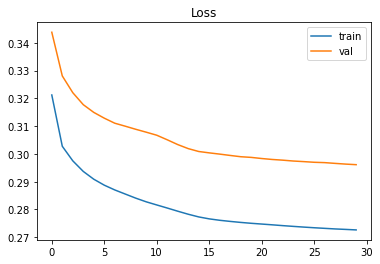

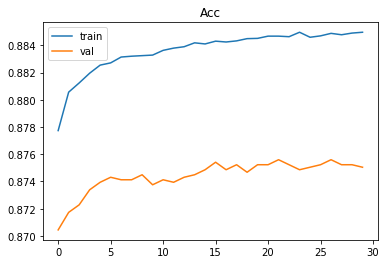

In [10]:
if __name__ == '__main__':
    main()